In [1]:
# This is to set the current working directory (CWD) to the root of the project
# Without, we cannot access DGA module
from pathlib import Path
import os
import sys
old_cwd = os.getcwd()
new_cwd = Path(os.getcwd()).parent.parent
os.chdir(new_cwd)
sys.path.append(str(old_cwd))

In [2]:
import numpy as np
from os.path import join as file_path
from DGA.Algorithm import Plateau_Genetic_Algorithm
from DGA.Model import Model
from DGA.Local import Synchronized
from DGA.Plotting import plot_model_logs

In [35]:
class Custom_Plateau_Algorithm(Plateau_Genetic_Algorithm):

  def __init__(self, penalty_modulator, max_penalty, **kwargs):
    super().__init__(**kwargs)
    self.penalty_modulator = penalty_modulator
    self.max_penalty = max_penalty

  def initial_gene(self, **kwargs):
    return np.random.normal(loc=0, scale=10, size=self.gene_shape)

  # Return mutated gene
  def mutate(self, gene, **kwargs):
    if np.random.rand() < self.mutation_rate:
      mutation_start = np.random.randint(0, np.prod(self.gene_shape))
      mutation_end = np.random.randint(mutation_start+1, mutation_start+2+(self.mutation_rate*5))
      if mutation_end > np.prod(self.gene_shape):
        mutation_end = np.prod(self.gene_shape)
      gene = gene.flatten()
      gene[mutation_start:mutation_end] += np.random.normal(loc=0, scale=self.mutation_rate*5, size=mutation_end-mutation_start)
    return gene.reshape(self.gene_shape)

  def founder_proximity_penalty(self, gene):
    penalty = min(super().founder_proximity_penalty(gene), self.max_penalty) # Cap penalty to radius
    norm_penalty = penalty / self.max_penalty    # Normalize penalty to 0-1
    return norm_penalty * self.penalty_modulator    # Apply modulator penalty

In [36]:
class Simple_Model(Model):  # <--- Remember to inherit Model class!
  def __init__(self, vector_size, **kwargs):
    super().__init__(**kwargs)
    if 'target_vector_1' in kwargs:   # Use previously initialized target vectors
      self.target_vector_1 = kwargs['target_vector_1']
      self.target_vector_2 = kwargs['target_vector_2']
      self.target_vector_3 = kwargs['target_vector_3']
    else:                             # Initialize targets when starting run
      self.target_vector_1 = np.random.normal(loc=0, scale=1, size=(vector_size, vector_size))
      self.target_vector_2 = np.random.normal(loc=0, scale=3, size=(vector_size, vector_size))
      self.target_vector_3 = np.random.uniform(low=-3, high=+3, size=(vector_size, vector_size))

  def run(self, gene, **kwargs) -> float:
    smallest_diff = np.inf
    for i, targ in enumerate([self.target_vector_1, self.target_vector_2, self.target_vector_3]):
      diff = np.linalg.norm(gene.flatten() - targ.flatten())
      if diff < smallest_diff:
        smallest_diff = diff
    return -smallest_diff

  def logger(self, fitness, iteration, **kwargs):
    log = super().logger(fitness, iteration, **kwargs)  # Get default log
    return log

In [37]:
def algorithm_tester(gene_size, max_penalty, run_dir=None):
	if run_dir is not None:		# Option to save run data to a specific directory
		run_name = file_path(run_dir, f"GS_size{gene_size}_pmod{max_penalty}")
	else:
		run_name = f"GS_size{gene_size}_pmod{max_penalty}"
	alg = Custom_Plateau_Algorithm(gene_shape=(gene_size, gene_size),
                                 num_genes=10,
                                 mutation_rate=1,
                                 mutation_decay=.99995,
                                 iterations_per_epoch=25_000,
                                 epochs=3,		# 3 epochs for 3 target vectors
                                 plateau_sensitivity=1e-5,
                                 plateau_sample_size=2000,
                                 warmup=2000,
																 penalty_modulator=max_penalty,
																 max_penalty=0.5,)
	mod = Simple_Model(vector_size=gene_size)
	local_runner = Synchronized(run_name=run_name, model=mod, algorithm=alg,)

	# Run model & plot results
	local_runner.run()

	# Find closest target vector for each foundation gene & count how many targets were found
	found_targets = [False, False, False]
	for _, gene_data in alg.founders_pool.items():
		smallest_diff = np.inf
		for i, targ in enumerate([mod.target_vector_1, mod.target_vector_2, mod.target_vector_3]):
			diff = np.linalg.norm(gene_data['gene'].flatten() - targ.flatten())
			if diff < smallest_diff:
				smallest_diff = diff
				found_targets[i] = True
	num_targs_found = sum(found_targets)
	return num_targs_found, len(local_runner.log)


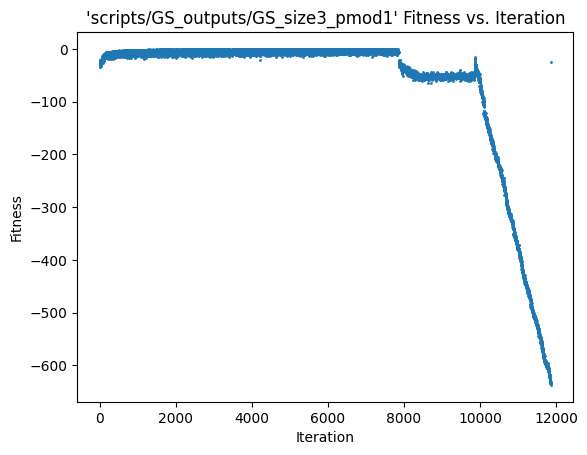

size: 3, pmod: 1, num_targs_found: 3, num_iters: 11861


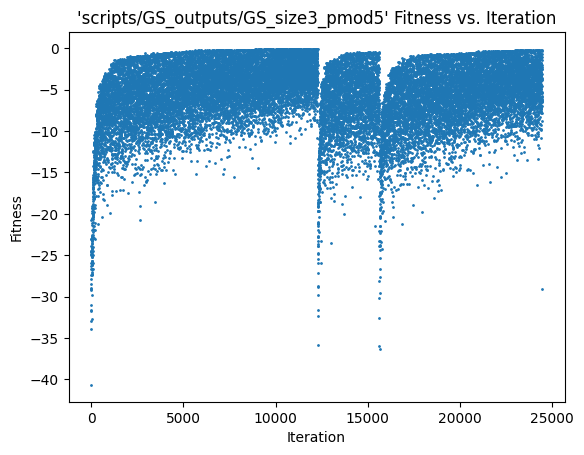

size: 3, pmod: 5, num_targs_found: 3, num_iters: 24437


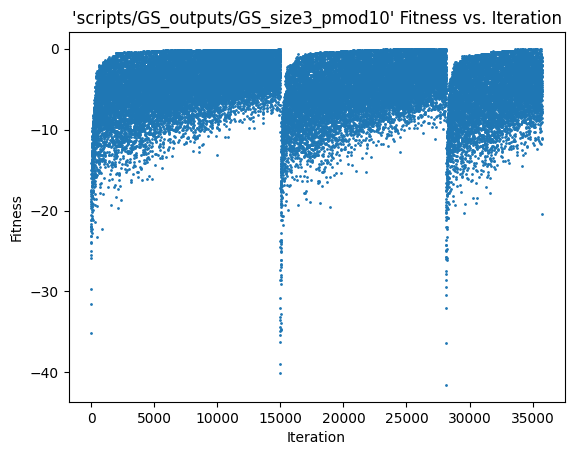

size: 3, pmod: 10, num_targs_found: 2, num_iters: 35740


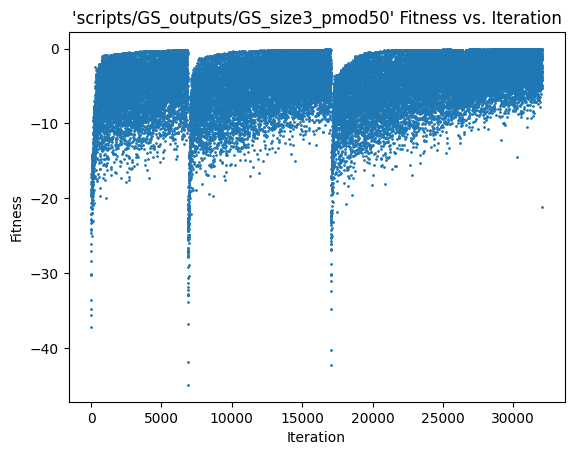

size: 3, pmod: 50, num_targs_found: 3, num_iters: 32042


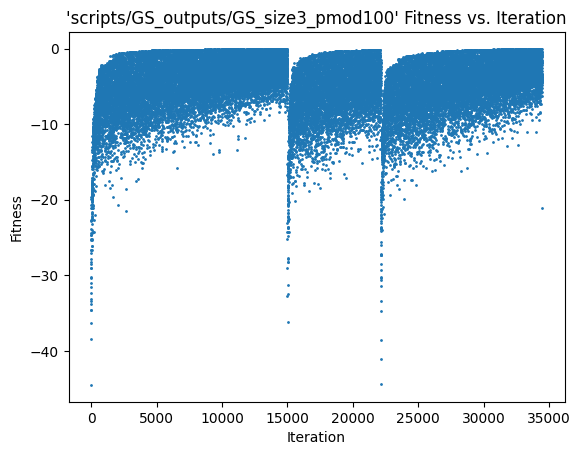

size: 3, pmod: 100, num_targs_found: 2, num_iters: 34446


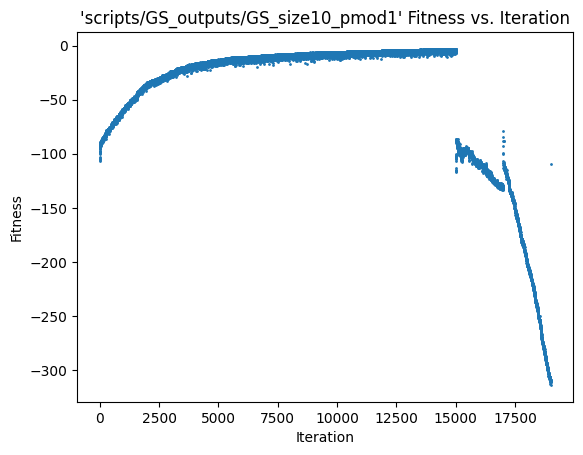

size: 10, pmod: 1, num_targs_found: 3, num_iters: 19002


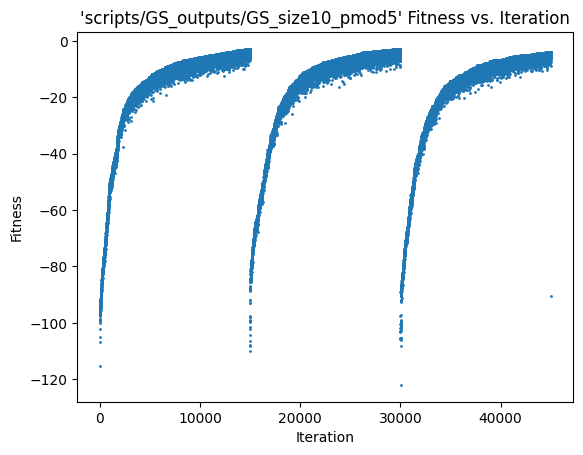

size: 10, pmod: 5, num_targs_found: 3, num_iters: 45000


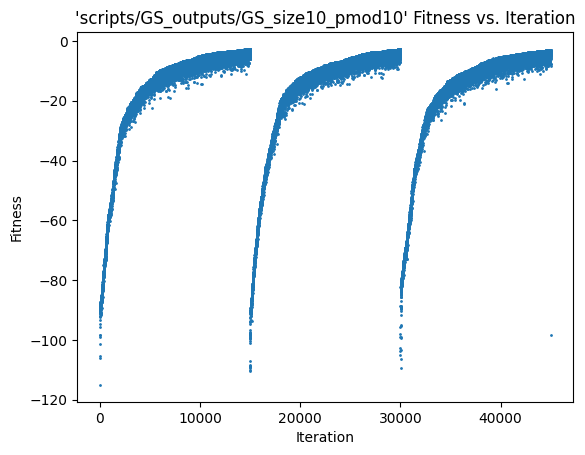

size: 10, pmod: 10, num_targs_found: 1, num_iters: 45000


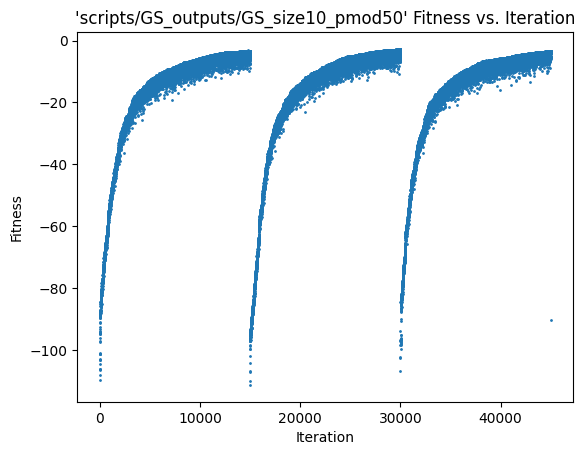

size: 10, pmod: 50, num_targs_found: 1, num_iters: 45000


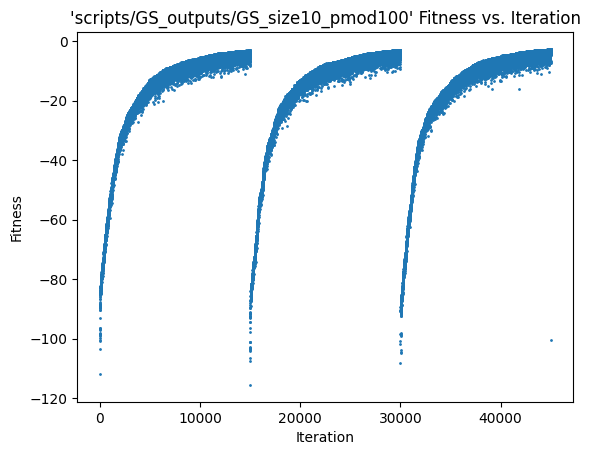

size: 10, pmod: 100, num_targs_found: 2, num_iters: 45000


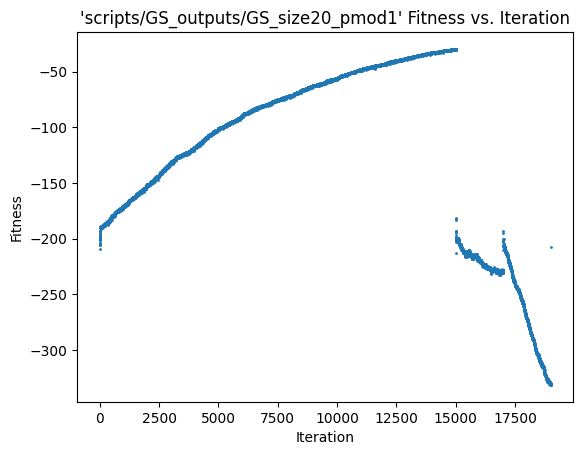

size: 20, pmod: 1, num_targs_found: 2, num_iters: 19002


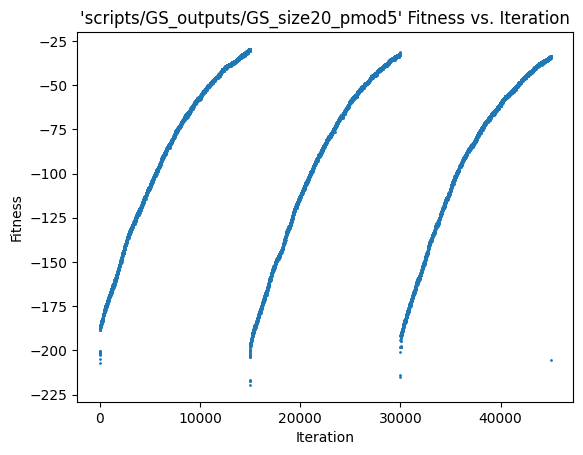

size: 20, pmod: 5, num_targs_found: 2, num_iters: 45000


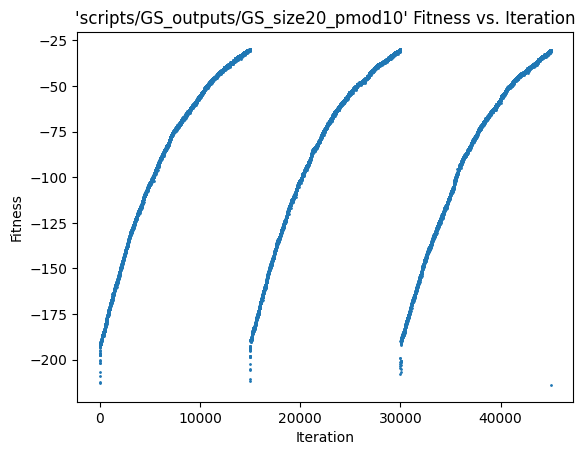

size: 20, pmod: 10, num_targs_found: 1, num_iters: 45000


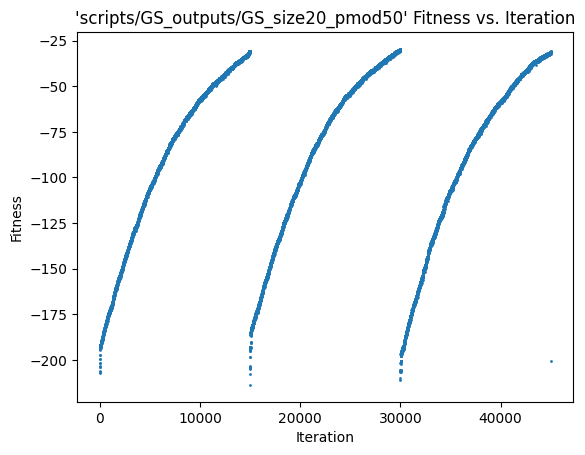

size: 20, pmod: 50, num_targs_found: 2, num_iters: 45000


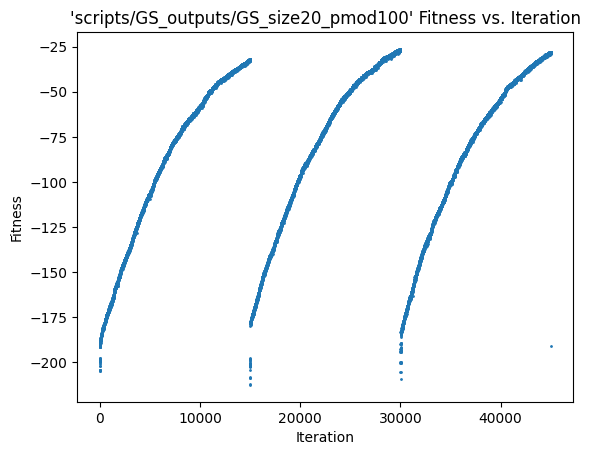

size: 20, pmod: 100, num_targs_found: 1, num_iters: 45000


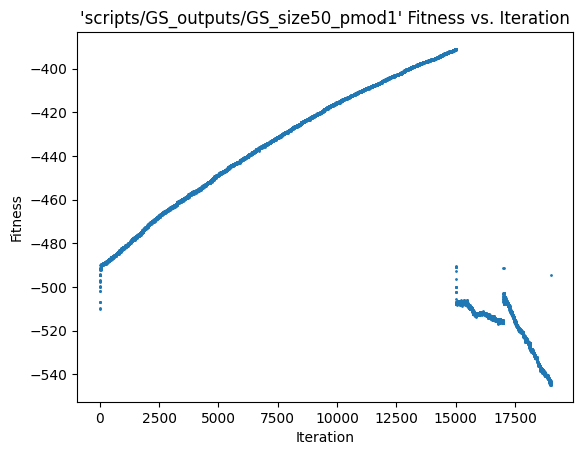

size: 50, pmod: 1, num_targs_found: 1, num_iters: 19002


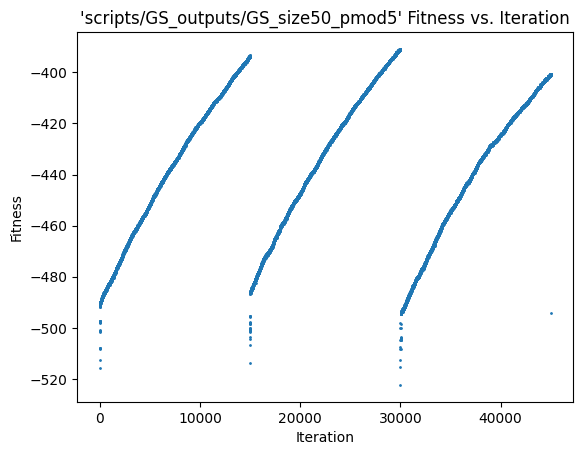

size: 50, pmod: 5, num_targs_found: 1, num_iters: 45000


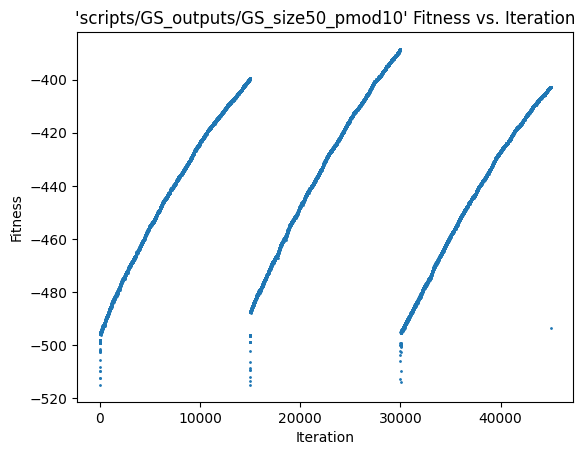

size: 50, pmod: 10, num_targs_found: 1, num_iters: 45000


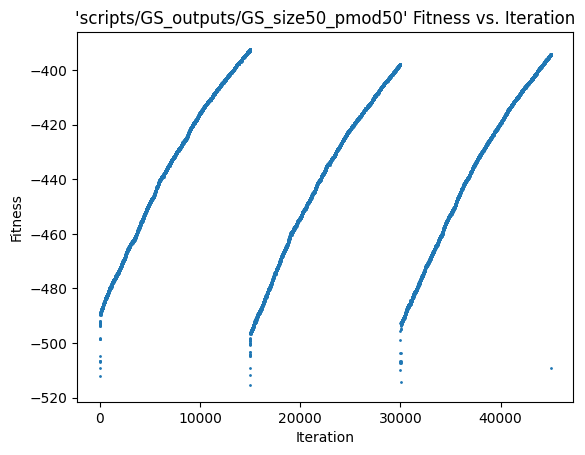

size: 50, pmod: 50, num_targs_found: 1, num_iters: 45000


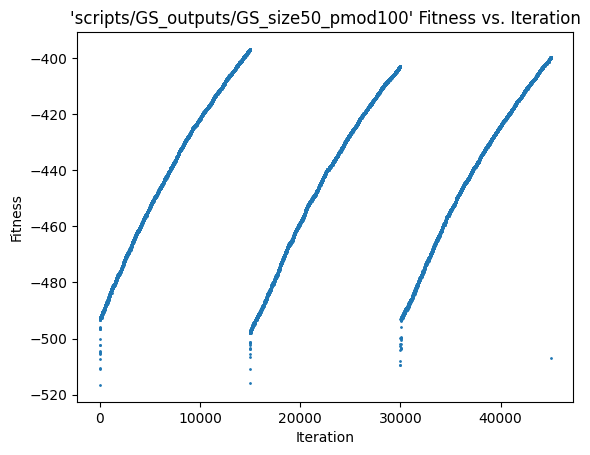

size: 50, pmod: 100, num_targs_found: 1, num_iters: 45000


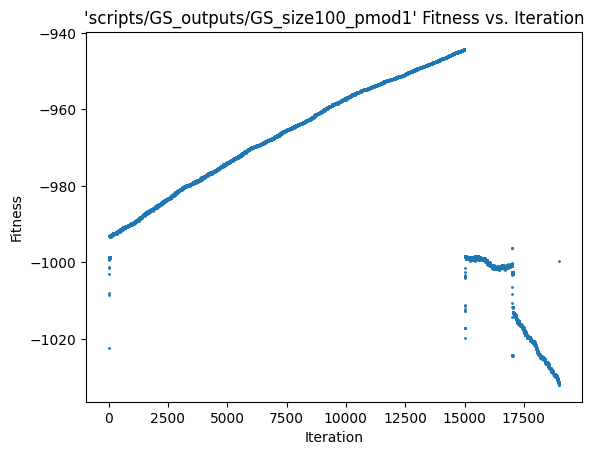

size: 100, pmod: 1, num_targs_found: 1, num_iters: 19002


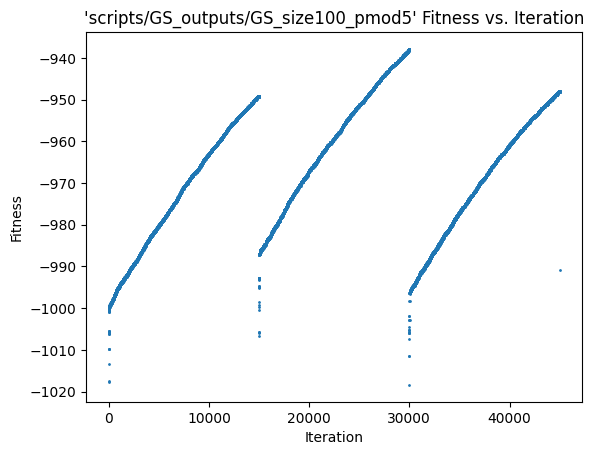

size: 100, pmod: 5, num_targs_found: 1, num_iters: 45000


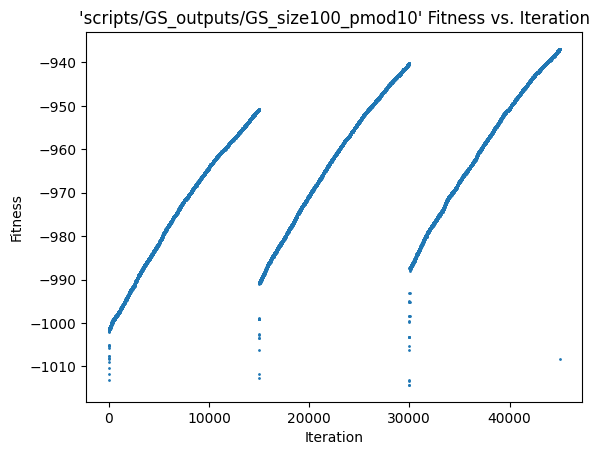

size: 100, pmod: 10, num_targs_found: 1, num_iters: 45000


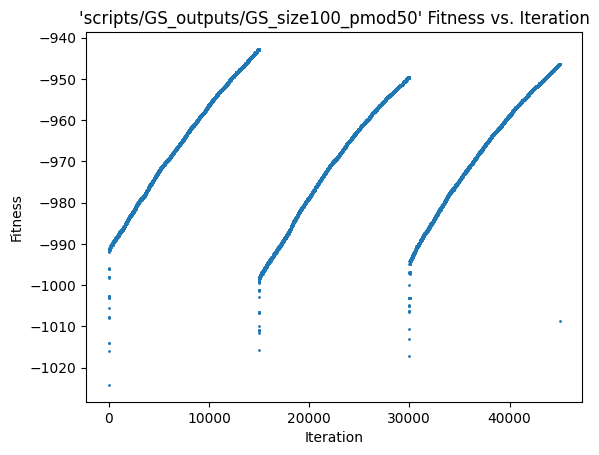

size: 100, pmod: 50, num_targs_found: 1, num_iters: 45000


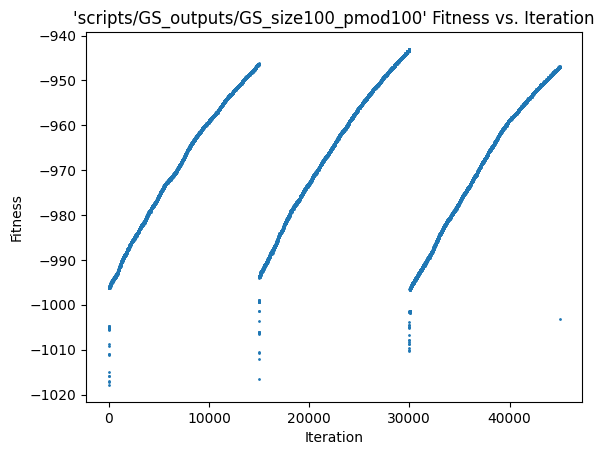

size: 100, pmod: 100, num_targs_found: 1, num_iters: 45000


In [34]:
gene_sizes = [3, 10, 20, 50]		# Gene sizes to test (square matrix)
max_penalty = [1, 3, 5, 10, 25, 50, 100] 		# Penalty modulator: 
max_penalty = [1, 2, 4, 8, 16, 32]
search_results = {}
for g_size in gene_sizes:
	for p_mod in max_penalty:
		num_targs_found, num_iters = algorithm_tester(g_size, p_mod, run_dir='scripts/GS_outputs')
		plot_model_logs(f"scripts/GS_outputs/GS_size{g_size}_pmod{p_mod}", num_models=1)
		search_results[(g_size, p_mod)] = (num_targs_found, num_iters)
		print(f"size: {g_size}, pmod: {p_mod}, num_targs_found: {num_targs_found}, num_iters: {num_iters}")